In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
import sys
sys.path.insert(0, '/home/xhding/workspaces/torch-deep-retina')
import os
import scipy
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyret
from kinetic.evaluation import *
from kinetic.utils import *
from kinetic.config import get_custom_cfg
from kinetic.data import *
from kinetic.notebook.functions import *

In [3]:
with h5py.File('/home/xhding/tem_stim/20-09-15/fullfield_whitenoise.h5', 'r') as f:
    stimulus =  np.asarray(f['test']['stimulus'][:, 25, 25]).astype('float32')
    resp = np.asarray(f['test']['response']['firing_rate_10ms'][0])

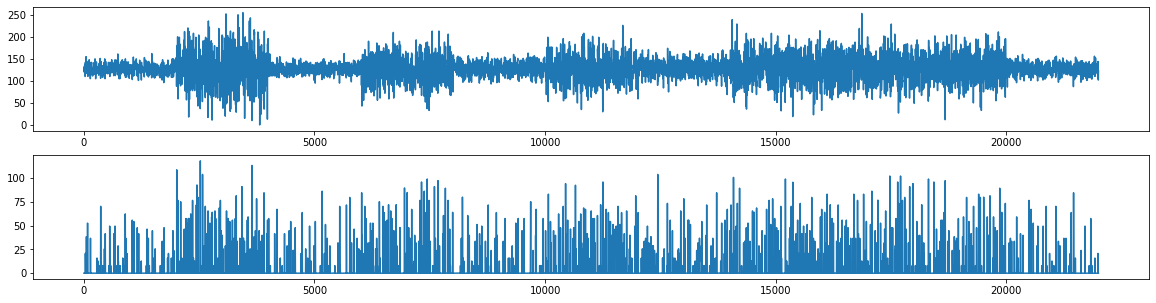

In [4]:
fig,ax = plt.subplots(2,1,figsize=(20,5))
ax[0].plot(stimulus)
ax[1].plot(resp)

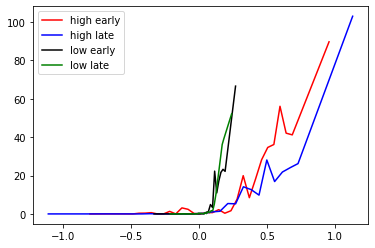

In [10]:
he, hl, le, ll = contrast_adaption_nonlinear(stimulus, resp, h_start=2000, l_start=4000)

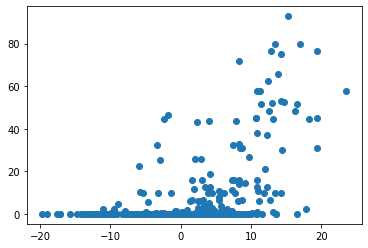

In [223]:
plt.plot(filtered_stim[filter_len:], resp_he[filter_len:], 'o')

In [16]:
device = torch.device('cuda:3')
cfg = get_custom_cfg('LNK')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/LNK/epoch_045_loss_1.40_pearson_0.5228.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
checkpoint['model_state_dict']['bias']=torch.tensor([-8.6525], device='cuda:3')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

LNK(
  (ln_filter): Temperal_Filter()
  (nonlinear): Sigmoid()
  (kinetics): Kinetics()
  (scale_shift): Linear(in_features=1, out_features=1, bias=True)
  (spiking): Softplus(beta=1, threshold=20)
)

In [7]:
test_data =  DataLoader(TestDatasetOnePixel(cfg, TrainDataset(cfg).stats), batch_size=1)
test_pc, pred, _ = pearsonr_eval_LNK_with_responses(model, test_data, 1, device)
pred = np.pad(pred[:, 0], (100, 0), 'constant', constant_values=(0,0))

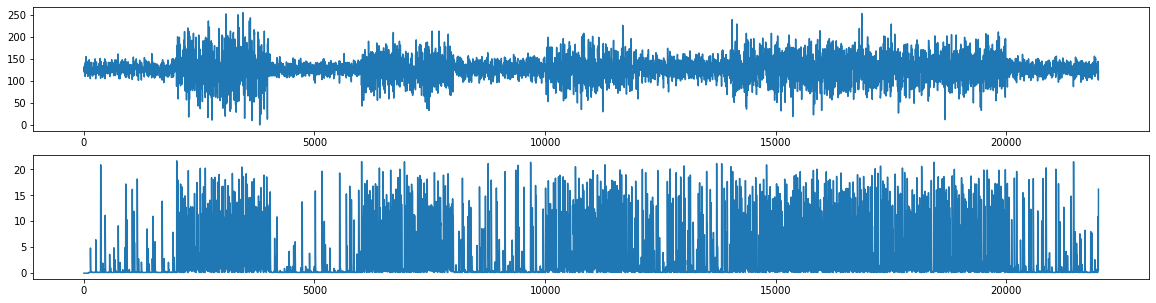

In [8]:
fig,ax = plt.subplots(2,1,figsize=(20,5))
ax[0].plot(stimulus)
ax[1].plot(pred)

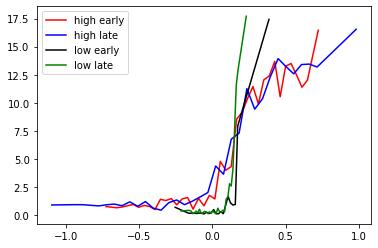

In [11]:
he, hl, le, ll = contrast_adaption_nonlinear(stimulus, pred, h_start=2000, l_start=4000)

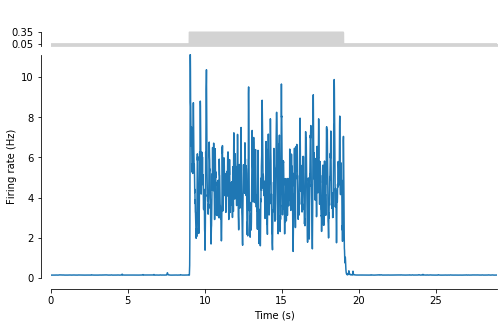

In [19]:
Rs, As, I1s, I2s, us = contrast_adaptation_LNK_inspect(model, device, c0=0.05, c1=0.35, duration=1000, delay=1000, nsamples=3000, filt_depth=100, n_repeats=10)

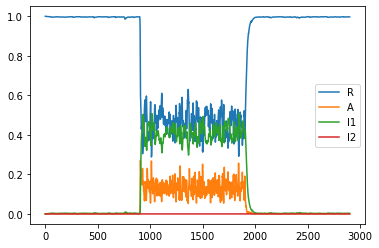

In [20]:
plt.plot(np.arange(2900),Rs[:], label='R')
plt.plot(np.arange(2900),As[:], label='A')
plt.plot(np.arange(2900),I1s[:], label='I1')
plt.plot(np.arange(2900),I2s[:], label='I2')
plt.legend()

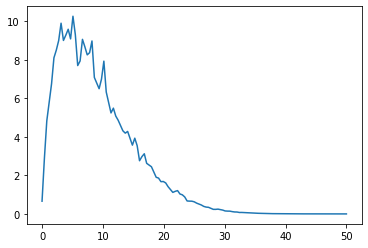

In [40]:
freq, power = scipy.signal.welch(resp, fs=100)
plt.plot(freq, power)

In [42]:
power.sum()/2

158.57023742634337

In [52]:
power[:21].sum()

163.00503990441658

7.039087454877219

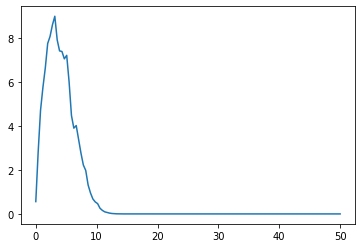

In [70]:
lp_filter = signal.firwin(25, 8, pass_zero='lowpass', fs=100)
freq, power = scipy.signal.welch(np.convolve(resp, lp_filter, 'valid'), fs=100)
plt.plot(freq, power)
np.convolve(resp, lp_filter, 'valid').std()

7.0064340246501775

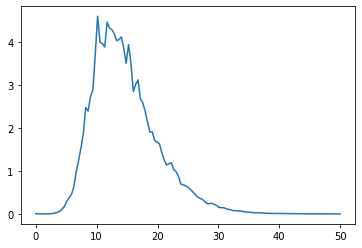

In [71]:
lp_filter = signal.firwin(25, 8, pass_zero='highpass', fs=100)
freq, power = scipy.signal.welch(np.convolve(resp, lp_filter, 'valid'), fs=100)
plt.plot(freq, power)
np.convolve(resp, lp_filter, 'valid').std()

In [85]:
torch.tensor(resp)[None, None,:].repeat(5,3,1).shape

torch.Size([5, 3, 22002])

In [86]:
y_targ = torch.tensor(resp)[None, None,:].repeat(5,3,1).to(device)
num_units = 3
numtaps = 25
f = 8
fs = 100
conv_filters = {}
for pass_zero in ['lowpass', 'highpass']:
    lp_filter = signal.firwin(numtaps, f, pass_zero=pass_zero, fs=fs)
    conv_filter = torch.nn.Conv1d(num_units, num_units, numtaps, groups=num_units, bias=False)
    conv_filter.weight.data = torch.from_numpy(np.flip(lp_filter).copy())[None, None, :].repeat(num_units, 1, 1)
    conv_filter.weight.requires_grad = False
    conv_filter = conv_filter.to(device)
    conv_filters[pass_zero] = conv_filter

y_targ_low = conv_filters['lowpass'](y_targ)
y_targ_high = conv_filters['highpass'](y_targ)

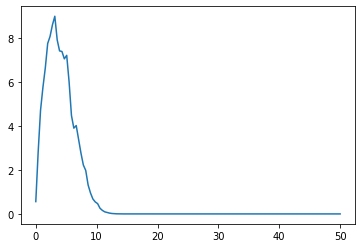

In [89]:
freq, power = scipy.signal.welch(y_targ_low.detach().cpu().numpy()[4,2,:], fs=100)
plt.plot(freq, power)

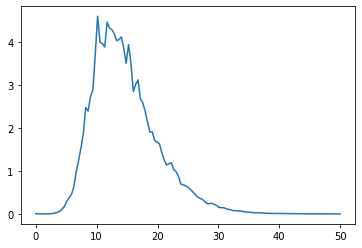

In [82]:
freq, power = scipy.signal.welch(y_targ_high.detach().cpu().numpy()[0,0,:], fs=100)
plt.plot(freq, power)

In [93]:
from torchdeepretina.datas import loadexpt
data_natural = loadexpt('20-09-15', 'all', 'naturalscene', 'train',
                40, 0, data_path='/home/xhding/tem_stim')
data_noise = loadexpt('20-09-15', 'all', 'fullfield_whitenoise', 'train',
                40, 0, data_path='/home/xhding/tem_stim')

val_size = 30000
len_natural = data_natural.y.shape[0]
len_noise = data_noise.y.shape[0]
n_split = 5
X_natural = data_natural.X[:-val_size]
y_natural = data_natural.y[:-val_size]
X_noise = data_noise.X[:-val_size]
y_noise = data_noise.y[:-val_size]

In [108]:
each_len_natural =  len_natural // n_split
each_len_noise = len_noise // n_split
mask = np.concatenate((np.ones(each_len_natural), np.zeros(each_len_noise)))
mask = np.tile(mask, n_split-1)
mask = np.concatenate((mask, np.ones(len_natural-val_size-(n_split-1)*each_len_natural)))
mask = np.concatenate((mask, np.zeros(len_noise-val_size-(n_split-1)*each_len_noise)))

In [120]:
index = 130000
stim_type = mask[index]
mask[index], (mask[:index] == stim_type).sum()

(1.0, 76008)

In [110]:
len_natural+len_noise-2*val_size

509937

In [97]:
X_natural.shape

(269977, 40, 50, 50)